In [10]:
import pandas as pd
from typing import *
import re
# from fpgrowth_py import fpgrowth
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import split
# from pyspark.sql.types import ArrayType, StringType, StructField, StructType
import numpy as np
import matplotlib.pyplot as plt

In [11]:
files = pd.concat([pd.read_csv(r"../Generated_Result/9k.csv", sep=",").fillna("None"), \
                   pd.read_csv(r"../Generated_Result/40k.csv", sep=",").fillna("None")], axis=0, ignore_index=True)
obj = files.iloc[:, :3]
for col in obj.columns:
    obj[col] = obj[col].apply(lambda x: np.nan if "none" in x.lower() else x)
print(files.shape)

(35839, 4)


In [12]:
sets = obj.values.tolist()

In [13]:
np.isnan(sets[0][-1])
print(sets[0])

['Study on the impact of groundwater exploitation on soil properties and water quality in the Ouargla Basin', 'Salinity in soil due to excessive groundwater pumping|exceeding authorized standards. Values range from 2.4 g/L to 150 g/L in certain areas of the Ouargla Basin', nan]


In [14]:
for idx, subset in enumerate(sets):
    subset = [val.split("|") for val in subset if not pd.isnull(val)]
    subset = [item.strip() for yitem in subset for item in yitem]
    sets[idx] = subset

In [15]:
from functools import singledispatch

@singledispatch
def myFunc(marker, val):
    print("This is the default function")

@myFunc.register(float)
def _(marker: float, val: List[str]):
    pattern = r'\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b'
    processed_list = [item for item in val if not re.search(pattern, item)]
    return processed_list

@myFunc.register(int)
def _(marker: int, val: List[str]):
    print(fr"the marker type is {type(marker)}, it will clean the duplicated value.")
    pattern = r'\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b'
    processed_list = [item for item in val if not re.search(pattern, item)]
    return list(set(processed_list))

In [16]:
testing_pattern = r"\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b"
words1, word2, word3, word4 = "here is a pattern owns 1.0 and 2.0", \
                          "here is a pattern owns 1 and 2", \
                          "here is a pattern owns no number",\
                          "000"
for word in [words1, word2, word3, word4]:
    print(re.search(testing_pattern, word))

<re.Match object; span=(23, 26), match='1.0'>
None
None
<re.Match object; span=(0, 3), match='000'>


39 39


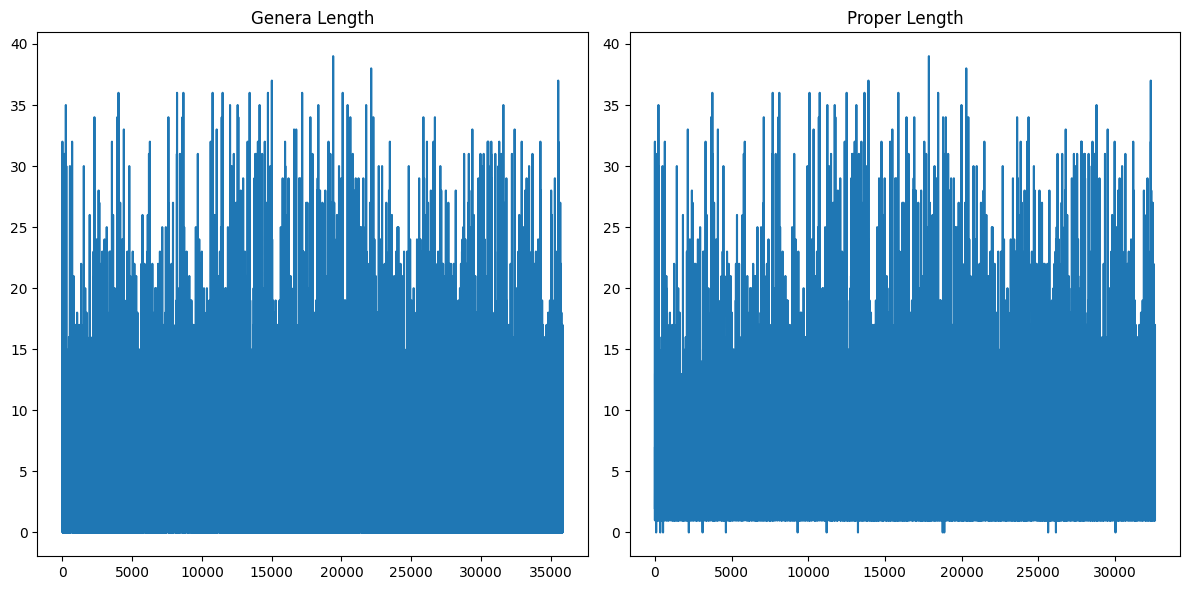

In [17]:
sets_proper = [myFunc(1.0, val) for val in sets if val ]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
generaLength, properLength = [len(subitem) for subitem in sets], [len(subitem) for subitem in sets_proper]
print(max(generaLength), max(properLength))
ax[0].plot(generaLength)  # Plot the first horizontal bar chart
ax[0].set_title('Genera Length')  # Add a title to the first subplot

ax[1].plot(properLength)  # Plot the second horizontal bar chart
ax[1].set_title('Proper Length')  # Add a title to the second subplot

plt.tight_layout()  # Adjust the spacing between subplots if necessary
plt.show()  # Display the plot

In [18]:
# sets_proper = filter(myFunc, sets)
# sets_proper=list(sets_proper)

### FP Growth Testing

In [20]:
import time
from utils import *
from my_fpgrowth import *
time1 = time.time()
# root = SycNode("root", None)
# headerTable, root = general_call(sets_proper, 4, root=root)
# print(f"Time taken is {time.time() - time1}")

In [ ]:
def simlarity_compute():
    ...

Root:  root
Childs are: researchers
Root:  researchers
Childs are: 


### FP Growth Using Mlxtend

In [22]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
test_list = [
    ['f', 'a', 'c', 'd', 'g', 'i', 'm', 'p'],
    ['a', 'b', 'c', 'f', 'l', 'm', 'o'],
    ['b', 'f', 'h', 'j', 'o'],
    ['b', 'c', 'k', 's', 'p'],
    ['a', 'f', 'c', 'e', 'l', 'p', 'm', 'n'],
    ['f', 'c','g','s']
]

In [23]:
dataset, freq = sets_proper, 4
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [40]:
frequentItemset = fpgrowth(df, min_support= freq/len(dataset), use_colnames=True)
rules = association_rules(frequentItemset, metric="confidence", min_threshold=0.4)
print(rules.shape, frequentItemset.shape)

(4363, 10) (8761, 2)


In [45]:
rules.loc[:, ["antecedents", "consequents"]] = rules.loc[:, ["antecedents", "consequents"]].applymap(lambda x: "| ".join(list(x)))
rules.head()

C:\Users\jqi22\AppData\Local\Temp\ipykernel_9744\640061805.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rules.loc[:, ["antecedents", "consequents"]] = rules.loc[:, ["antecedents", "consequents"]].applymap(lambda x: "| ".join(list(x)))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,study| engineers,researchers,0.000215,0.021644,0.000184,0.857143,39.600971,0.000179,6.848489,0.974957
1,researchers| study,analysis,0.000521,0.010332,0.000215,0.411765,39.854425,0.000209,1.682436,0.975417
2,analysis| policymakers,researchers,0.000307,0.021644,0.000153,0.500000,23.100567,0.000147,1.956711,0.957004
3,study| policymakers,analysis,0.000245,0.010332,0.000153,0.625000,60.493323,0.000151,2.639115,0.983711
4,analysis| policymakers,study,0.000307,0.013275,0.000153,0.500000,37.665127,0.000149,1.973450,0.973749


In [46]:
rules.to_csv(rf"../Generated_Result/association_rules_{files.shape[0]}.csv", index=False)